# [Genre] Feedforward Baseline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
import os
import json
import pickle
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics 

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import utils
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [ ]:
DRIVE_PATH = '/content/drive/My Drive/'
sys.path.append(DRIVE_PATH)

import utility
from utility import DataGenerator

MELSPEC_DIR = DRIVE_PATH + 'genre-melspecs-19000/'
SPLITS_DIR = DRIVE_PATH + 'genre-splits/experiment-2/'
FNN_PATH = DRIVE_PATH + 'genre-models/fnn-baseline/'
RESULTS_DIR = DRIVE_PATH + 'genre-results/'

NUM_CLASSES = 10
NUM_EPOCHS = 20
BATCH_SIZE = 128
L2_LAMBDA = 0.001

# 1. Loading the data

In [ ]:
# Loading the label map
with open(DRIVE_PATH + 'genre_label_map.json', 'r') as output:
    label_map = json.load(output)

label_map

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [ ]:
# Loading the splits
X_train_filenames = np.load(SPLITS_DIR + 'X_train_filenames_melspec.npy')
X_val_filenames = np.load(SPLITS_DIR + 'X_val_filenames_melspec.npy')
X_test_filenames = np.load(SPLITS_DIR + 'X_test_filenames_melspec.npy')

one_hot_y_train = np.load(SPLITS_DIR + 'one_hot_y_train_melspec.npy')
one_hot_y_val = np.load(SPLITS_DIR + 'one_hot_y_val_melspec.npy')
one_hot_y_test = np.load(SPLITS_DIR + 'one_hot_y_test_melspec.npy')

In [ ]:
print('Mel spectrograms')
print("Train set:", X_train_filenames.shape, one_hot_y_train.shape)
print("Validation set:", X_val_filenames.shape, one_hot_y_val.shape)
print("Test set:", X_test_filenames.shape, one_hot_y_test.shape)

Mel spectrograms
Train set: (15200,) (15200, 10)
Validation set: (1900,) (1900, 10)
Test set: (1900,) (1900, 10)


# 2. Creating generators


In [ ]:
X_train_filenames[0]

'blues.00055.13.melspec.npy'

In [ ]:
# Replacing filenames by the absolute path to filenames
X_train_filenames = np.array([MELSPEC_DIR + fn for fn in X_train_filenames])
X_val_filenames = np.array([MELSPEC_DIR + fn for fn in X_val_filenames])
X_test_filenames = np.array([MELSPEC_DIR + fn for fn in X_test_filenames])

In [ ]:
X_train_filenames[0]

'/content/drive/My Drive/genre-melspecs-19000/blues.00055.13.melspec.npy'

In [ ]:
x = np.load(X_train_filenames[0])
IMG_WIDTH, IMG_HEIGHT = x.shape
x.shape

(128, 130)

In [ ]:
train_generator = DataGenerator(X_train_filenames, one_hot_y_train, BATCH_SIZE, input_shape=(IMG_WIDTH, IMG_HEIGHT))
validation_generator = DataGenerator(X_val_filenames, one_hot_y_val, BATCH_SIZE, input_shape=(IMG_WIDTH, IMG_HEIGHT))
test_generator = DataGenerator(X_test_filenames, one_hot_y_test, BATCH_SIZE, input_shape=(IMG_WIDTH, IMG_HEIGHT))

# 3. Building and training the model

In [ ]:
# Creating callbacks list
checkpoint_path = FNN_PATH + 'fnn_mel_epoch_{epoch:02d}_acc_{accuracy:.4f}_val_acc_{val_accuracy:.4f}.h5'
checkpoint = ModelCheckpoint(checkpoint_path, 
                            monitor='val_accuracy', 
                            verbose=0, 
                            save_best_only=False)

reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', 
                                         factor=0.1, 
                                         patience=1, 
                                         verbose=0)

callbacks_list = [checkpoint, reduce_lr_on_plateau]

In [ ]:
# Building the model
model = Sequential()
model.add(Flatten(input_shape=(IMG_WIDTH, IMG_HEIGHT), name='flatten'))

# 1st hidden layer
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='dense_1'))
model.add(Dropout(0.3, name='dropout_1'))

# 2nd hidden layer
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='dense_2'))
model.add(Dropout(0.3, name='dropout_2'))

# 3rd hidden layer
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='dense_3'))
model.add(Dropout(0.3, name='dropout_3'))

# Output layer
model.add(Dense(NUM_CLASSES, activation='softmax', name='dense_output'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 16640)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8520192   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

In [ ]:
# Compiling the network
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(0.0001),
              metrics=['accuracy'])

In [ ]:
STEPS_PER_EPOCH = np.ceil(len(X_train_filenames)/BATCH_SIZE)
VAL_STEPS = np.ceil(len(X_val_filenames)/BATCH_SIZE)

# Training the network
history = model.fit(x=train_generator,
                    epochs=NUM_EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=validation_generator,
                    validation_steps=VAL_STEPS,
                    callbacks=callbacks_list)

Epoch 1/20
119/119 [==============================] - 64s 535ms/step - loss: 2.8601 - accuracy: 0.1029 - val_loss: 2.5896 - val_accuracy: 0.0937 - lr: 1.0000e-04
Epoch 2/20
119/119 [==============================] - 63s 533ms/step - loss: 2.4781 - accuracy: 0.1224 - val_loss: 2.3467 - val_accuracy: 0.1526 - lr: 1.0000e-04
Epoch 3/20
119/119 [==============================] - 64s 536ms/step - loss: 2.3654 - accuracy: 0.1374 - val_loss: 2.3287 - val_accuracy: 0.1653 - lr: 1.0000e-04
Epoch 4/20
119/119 [==============================] - 65s 542ms/step - loss: 2.3213 - accuracy: 0.1414 - val_loss: 2.2929 - val_accuracy: 0.1653 - lr: 1.0000e-04
Epoch 5/20
119/119 [==============================] - 63s 528ms/step - loss: 2.3066 - accuracy: 0.1489 - val_loss: 2.2557 - val_accuracy: 0.1926 - lr: 1.0000e-04
Epoch 6/20
119/119 [==============================] - 63s 526ms/step - loss: 2.2903 - accuracy: 0.1564 - val_loss: 2.2329 - val_accuracy: 0.1953 - lr: 1.0000e-04
Epoch 7/20
119/119 [========

In [ ]:
# Saving scores on train and validation sets
with open(DRIVE_PATH + 'pickles/feed_forward_baseline_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Determining the best performing model based on val_accuracy

In [ ]:
# Loading scores
with open(DRIVE_PATH + 'pickles/feed_forward_baseline_history.pkl', 'rb') as f:
    history_dict = pickle.load(f)

print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


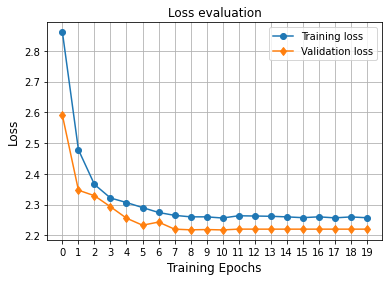

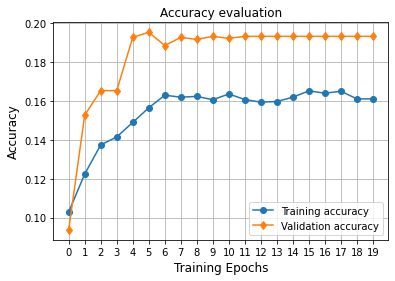

In [ ]:
utility.plot_history(history_dict=history_dict, num_epochs=NUM_EPOCHS, save_path=FNN_PATH + 'fnn_baseline')

In [ ]:
# Loading the best performing model
model = load_model(filepath=FNN_PATH + 'fnn_mel_epoch_15_acc_0.1619_val_acc_0.1932.h5')

It performs slightly better than a 'dumb' classifier which assigns all predictions to the same class (accuracy = 10%)

# 4. Evaluating the best performing model

In [ ]:
# Making predictions on test set
TEST_STEPS = np.ceil(len(X_test_filenames)/BATCH_SIZE)
pred_proba = model.predict(x=test_generator, steps=TEST_STEPS)

In [ ]:
y_pred = np.argmax(pred_proba, axis=1)
y_test = np.argmax(one_hot_y_test, axis=1)

In [ ]:
accuracy = metrics.accuracy_score(y_pred, y_test)
precision_macro = metrics.precision_score(y_pred, y_test, average='macro')
recall_macro = metrics.recall_score(y_pred, y_test, average='macro', labels=np.unique(y_pred))
f1_score_macro = metrics.f1_score(y_pred, y_test, average='macro')
roc_auc_macro = metrics.roc_auc_score(one_hot_y_test, pred_proba, average='macro')

In [ ]:
header = ['model', 'accuracy', 'precision_macro', 'recall_macro', 'f1_score_macro', 'roc_auc_macro']

scores = ['fnn_baseline', accuracy, precision_macro, recall_macro, f1_score_macro, roc_auc_macro]

with open(RESULTS_DIR + 'genre_all_models_scores.csv', 'w') as csv_file:
  writer = csv.writer(csv_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
  writer.writerow(header)
  writer.writerow(scores)